In [1]:
# NOTE: probleme with librosea -> had to remove broadbeck.py

In [2]:
# pip install webdavclient3
# downloader: chmod
# librosa problem

In [3]:
from platform import python_version

assert python_version() == '3.8.0'

In [5]:
import bm
from bm.studies.pallier2023 import *
import mne
import spacy
mne.set_log_level(False)

/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [6]:
def load_events(self):
    """
    to plug in PR
    """
    raw = self.raw()
    path = StudyPaths().download
    bids_path = BIDSPath(
        subject=self.subject_uid[4:],
        session="01",
        run=self.run,
        task="listen",
        root=path,
        datatype="meg",
    )

    # extract annotations
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()
    meta = pd.read_csv(event_file, sep="\t")
    meta['word'] = [eval(w)['word'] for w in meta.trial_type]
    meta['kind'] = [eval(w)['kind'] for w in meta.trial_type]
    
    events = self.raw_events

    # word events
    # match events and metadata
    word_events = events[events[:, 2] > 1]
    meg_delta = np.diff(word_events[:, 0].astype(float) / raw.info["sfreq"])
    meta_delta = np.diff(meta.onset.values)

    pres = 1e2
    i, j = utils.match_list(np.round(meg_delta*pres), np.round(meta_delta*pres))
    assert len(i) / len(meg_delta) > .95
    assert len(i) > 500
    meta = meta.iloc[j].reset_index(drop=True)
    meta["start"] = word_events[i, 0] / self.raw().info["sfreq"]

    # Sound events
    CHAPTERS = {
        1: "1-3",
        2: "4-6",
        3: "7-9",
        4: "10-12",
        5: "13-14",
        6: "15-19",
        7: "20-22",
        8: "23-25",
        9: "26-27",
    }

    # Event start and end:
    idx = [np.where(events[:, 2] == 1)[0][0]]
    sound_start = events[idx, 0] / self.raw().info["sfreq"]
    assert len(sound_start) == 1
    sound_start = sound_start[0]
    chapter = CHAPTERS[self.run_uid]

    sound_event = []
    sound_path = path / "stimuli" / f"ch{chapter}.wav"
    assert sound_path.exists()
    sound_event.append(
        dict(kind="sound", filepath=sound_path, start=sound_start)
    )

    meta = pd.concat([meta, pd.DataFrame(sound_event)], ignore_index=True)
    meta["condition"] = "sentence"
    meta = meta.sort_values('start').reset_index(drop=True)
    
    # add parsing data
    meta = enrich(meta, path/'stimuli'/f'ch{chapter}.txt')
    
    return meta[['start', 'duration', 'kind', 'word', 'filepath', 'condition', 'sequence_id', 'sequence_uid', 'word_index', 'closing_', 'match_token']]

In [7]:
def parse(sent):
    'identifies the number of closing nodes'

    def is_closed(node, position):
        """JR quick code to know whether is a word is closed given a word position"""
        if node.i > position:
            return False
        for child in node.children:
            if child.i > position:
                return False
            if not is_closed(child, position):
                return False
        return True

    closeds = []
    for current in range(1, len(sent)+1):
        closed = 0
        for position, word in enumerate(sent): # [:current]
            closed += is_closed(word, current)
        closeds.append(closed)

    closing = np.r_[np.diff(closeds), closeds[-1]]
    return closing


class Enrich():
    """Enrich word dataframes (e.g. mne.Epochs.metadata) with syntactic information"""
    def __init__(self,):
        model = 'fr_core_news_sm'
        if not spacy.util.is_package(model):
            spacy.cli.download(model)
    
        self.nlp = spacy.load(model)

    def __call__(self, meta, txt_file):

        # read text file
        with open(txt_file, 'r') as f:
            txt = f.read().replace('\n', '')

        # parse text file
        doc = self.nlp(txt)

        # add parse information to metadata
        parse_annots = []
        for sent_id, sent in enumerate(doc.sents):
            # HERE ADD ERIC DE LA CLERGERIE parser instead
            closings = parse(sent)
            assert len(closings) == len(sent)
            for word, closing in zip(sent, closings):
                parse_annots.append(dict(
                    word_index=word.i - sent[0].i,
                    sequence_id=sent_id,
                    sequence_uid=str(sent),
                    closing=closing,
                    match_token=word.text,
                ))
        
        # align text file and meg metadata
        def format_text(text):
            for char in ('jlsmtncd'):
                text = text.replace(f"{char}'", char)
            text = text.replace('œ', 'oe')
            return text.lower()

        meg_words = meta.word.fillna('######').values
        text_words = [format_text(w.text) for w in doc]
        
        i, j = utils.match_list(meg_words, text_words)
        
        # deal with missed tokens (e.g. wrong spelling, punctuation)
        assert len(parse_annots) == len(text_words)
        parse_annots = pd.DataFrame(parse_annots)
        parse_annots.closing = parse_annots.closing.fillna(0)
        parse_annots['closing_'] = 0
        parse_annots['missed_closing'] = 0
        missing = np.setdiff1d(range(len(parse_annots)), j)
        for missed in missing:
            current_closing = parse_annots.iloc[missed].closing
            prev_word = parse_annots.iloc[[missed-1]].index
            if prev_word[0] >=0:
                parse_annots.loc[prev_word, 'missed_closing'] = current_closing
        parse_annots.closing_ = parse_annots.closing + parse_annots.missed_closing
        
        # Add new columns to original mne.Epochs.metadata
        # fill columns
        columns = ('word_index', 'sequence_id', 'sequence_uid', 'closing_', 'match_token')
        for column in columns:
            meta[column] = None
            meta.loc[meta.iloc[i].index, column] = parse_annots[column].iloc[j].values
        return meta

In [8]:
enrich = Enrich()

In [9]:
for rec in Pallier2023Recording.iter():
    break

In [10]:
meta = load_events(rec)

/data/home/jeanremi/projects/brainmagick/bm/studies/pallier2023.py:133: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = read_raw_bids(bids_path)  # FIXME this is NOT a lazy read
/data/home/jeanremi/projects/brainmagick/bm/studies/pallier2023.py:133: RuntimeWarning: The unit for channel(s) MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC201, MISC202, MISC203, MISC204, MISC205, MISC206, MISC301, MISC302, MISC303, MISC304, MISC305, MISC306 has changed from V to NA.
  raw = read_raw_bids(bids_path)  # FIXME this is NOT a lazy read


In [11]:
words = meta.query('kind=="word"')
raw = rec.raw()
raw.load_data()
raw.filter(.5, 20., n_jobs=-1);

In [12]:
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = meta.start*raw.info['sfreq']
    return dict(events=events, metadata=meta.reset_index())

In [13]:
epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=.8)
epochs = epochs['kind=="word"']

/tmp/ipykernel_55333/2318108982.py:1: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=.8)


In [14]:
epochs.load_data()

Number of events,1593
Events,1: 1593
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [15]:
evo = epochs.average(method='median')

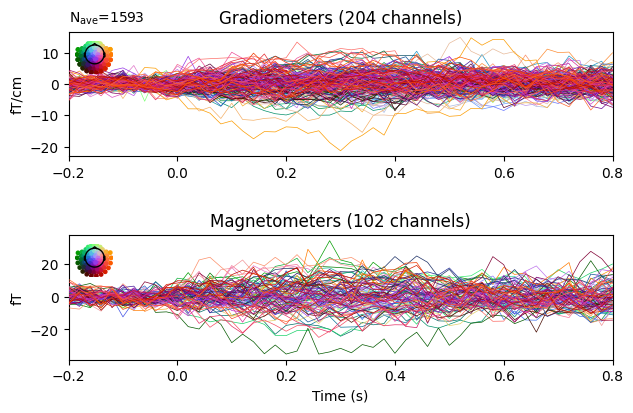

In [16]:
evo.plot();

In [17]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from wordfreq import zipf_frequency


def decod(epochs, target):
    model = make_pipeline(StandardScaler(), RidgeCV())
    cv = KFold(n_splits=5)

    y = epochs.metadata[target].values
    r = np.zeros(len(epochs.times))
    for t in trange(len(epochs.times)):
        X = epochs.get_data()[:, :, t]
        for train, test in cv.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            r[t] += pearsonr(y_pred, y[test])[0]
    r /= cv.n_splits
    return r

In [18]:
epochs.metadata['wfreq'] = epochs.metadata.word.apply(lambda w: zipf_frequency(w, 'fr')).values

  0%|          | 0/51 [00:00<?, ?it/s]

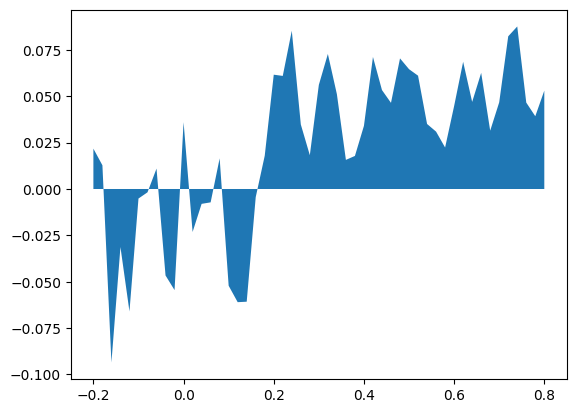

In [19]:
import matplotlib.pyplot as plt
r = decod(epochs, 'wfreq')
plt.fill_between(epochs.times, r)

In [20]:
epochs.metadata['closing'] = epochs.metadata.closing_.fillna(0)

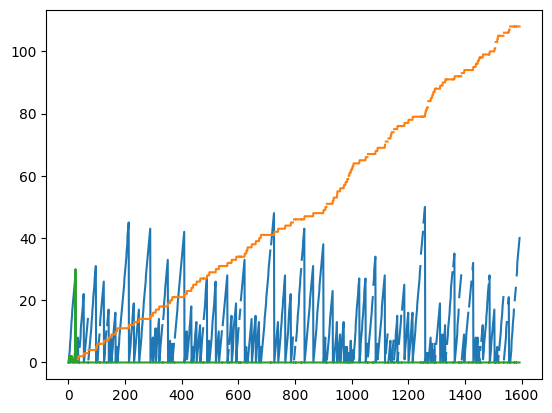

In [21]:
plt.plot(epochs.metadata.word_index)
plt.plot(epochs.metadata.sequence_id)
plt.plot(epochs.metadata.closing_)

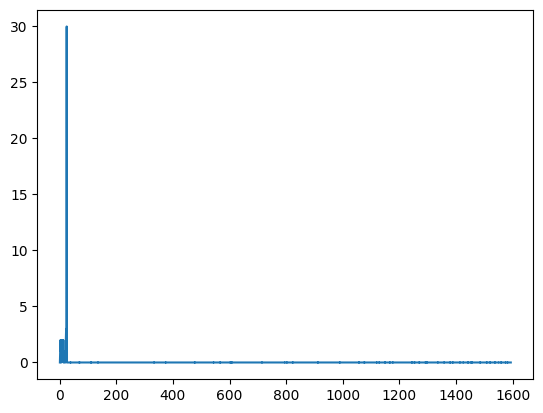

In [22]:
plt.plot(epochs.metadata.closing_)

In [ ]:
import matplotlib.pyplot as plt
r = decod(epochs, 'closing')
plt.fill_between(epochs.times, r)

  0%|          | 0/51 [00:00<?, ?it/s]

/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/home/jeanremi/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/home/jeanremi/anaconda3/en

In [ ]:
    for word_index, w in enumerate(epochs.metadata.word):
    print(colored(w, 'black' if word_index in i else 'red'), end=' ')

In [ ]:
for w in doc:
    print(colored(format_text(w.text), 'black' if w.i in j else 'red'), end=' ')